# Yacht Insurance Claims Data 
##### NOTEBOOK 3

**Problem Statement:** What is the likelihood that a yacht insurance policy has at least 1 claim within five years?

**Contents:**
1. Multiclass Classifcation Models
2. Basic Binary Classification Models: KNN, Logistic Regression, Random Forest, Extra Trees
3. Random Oversampling
4. SMOTE Oversampling and Random Undersampling
5. Logistic Regression with Regularization
6. Fine Tuning Random Forest Model
7. Results

___
## Import libraries and read in data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression, ElasticNetCV, LogisticRegressionCV
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [2]:
np.random.seed(42)

In [3]:
combined = pd.read_csv('../datasets/combined2.csv')

combined.head()

Years Exp.  Year Built  Length  Hull Limit  # Engines  num_claims  Age  \
0         2.0      1997.0    63.0    500000.0        2.0         0.0   73   
1        22.0      2006.0    61.0   1275000.0        2.0         0.0   69   
2        30.0      2001.0    48.0    400000.0        2.0         0.0   78   
3        20.0      1973.0    32.0     35000.0        0.0         0.0   44   
4        30.0      1989.0    43.0    200000.0        1.0         0.0   70   

   policy_length  New/Renl/Endt/Canc/Flat_endt  \
0         1759.0                             0   
1         1772.0                             0   
2         1760.0                             0   
3         1760.0                             0   
4         1757.0                             0   

   New/Renl/Endt/Canc/Flat_endt-canc  ...  Mooring County_sarasota  \
0                                  0  ...                        0   
1                                  0  ...                        0   
2                                  0  ...                        0   
3                                  0  ...                        0   
4                                  0  ...                        0   

   Mooring County_sinaloa  Mooring County_skagit  Mooring County_sonora  \
0                       0                      0                      0   
1                       0                      0                      0   
2                       0                      0                      0   
3                       0                      0                      0   
4                       0                      0                      0   

   Mooring County_south pacific  Mooring County_st. johns  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

   Mooring County_st. lucie  Mooring County_ventura  Mooring County_volusia  \
0                         0                       0                       0   
1                         0                       0                       0   
2                         0                       0                       0   
3                         0                       0                       0   
4                         0                       0                       0   

   Mooring County_whatcom  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 118 columns]

---

# MODELING: Multiclass Classification

**BELOW:** Initially we wanted to see if we could do a multiclass classification model to predict whether a boat might have 0, 1, 2, or 3 claims. Unfortunately, with so few examples for our models to train on for 2 or 3 claims, we decided to move forward with just binary (having 0 or at least 1 claim).

#### Establish a baseline

0 claims = 92%<br>
1 claim = 6.6%<br>
2 claims = 1%<br>
3 claims = 0.2%<br>

In [4]:
combined['num_claims'].value_counts()

0.0    5836
1.0     421
2.0      68
3.0      15
Name: num_claims, dtype: int64

In [5]:
combined['num_claims'].value_counts(normalize=True)

0.0    0.920505
1.0    0.066404
2.0    0.010726
3.0    0.002366
Name: num_claims, dtype: float64

In [6]:
combined['num_claims'].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
6335    0
6336    0
6337    0
6338    0
6339    0
Name: num_claims, Length: 6340, dtype: int64

### Train/Test split

In [7]:
X = combined.drop(columns=['num_claims'])
y = combined['num_claims']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

## 4 MODELS: KNN, Logistic Regression, Random Forest, Extra Trees
---

### StandardScaler

In [8]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Instantiate and fit 4 models

In [9]:
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_test_sc)

lr = LogisticRegression(max_iter=500,random_state=42)
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_test_sc)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train_sc, y_train)
rf_pred = rf.predict(X_test_sc)

et = ExtraTreesClassifier(n_estimators=100,random_state=42)
et.fit(X_train_sc, y_train)
et_pred = et.predict(X_test_sc)

### Get model results

In [10]:
print(classification_report(y_test, knn_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.928     0.988     0.957      1167
         1.0      0.294     0.060     0.099        84
         2.0      0.500     0.214     0.300        14
         3.0      1.000     0.667     0.800         3

    accuracy                          0.917      1268
   macro avg      0.680     0.482     0.539      1268
weighted avg      0.881     0.917     0.892      1268



In [11]:
print(classification_report(y_test, lr_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.923     0.999     0.960      1167
         1.0      0.000     0.000     0.000        84
         2.0      0.000     0.000     0.000        14
         3.0      1.000     1.000     1.000         3

    accuracy                          0.922      1268
   macro avg      0.481     0.500     0.490      1268
weighted avg      0.852     0.922     0.886      1268



In [12]:
print(classification_report(y_test, rf_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.940     0.997     0.968      1167
         1.0      0.769     0.119     0.206        84
         2.0      1.000     1.000     1.000        14
         3.0      1.000     1.000     1.000         3

    accuracy                          0.939      1268
   macro avg      0.927     0.779     0.794      1268
weighted avg      0.930     0.939     0.918      1268



In [13]:
print(classification_report(y_test, et_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.941     0.987     0.964      1167
         1.0      0.440     0.131     0.202        84
         2.0      0.875     1.000     0.933        14
         3.0      1.000     1.000     1.000         3

    accuracy                          0.931      1268
   macro avg      0.814     0.780     0.775      1268
weighted avg      0.907     0.931     0.913      1268



**INTERPRETATION:** Looking at these scores we can tell that the model is overfitting to 2 and 3 claims. The models are very good at identifying these minority classes but that's because 

---
# MODELING: Binary Classification

#### Establish a baseline

0 claims = 92%<br>
At least 1 claim = 7.9%<br>

In [14]:
# Create a column for binary classification
combined['binary'] = [1 if x > 0 else 0 for x in combined['num_claims']]
combined['binary'].value_counts(normalize=True)

0    0.920505
1    0.079495
Name: binary, dtype: float64

In [15]:
combined['binary'].value_counts()

0    5836
1     504
Name: binary, dtype: int64

**BELOW:** We decided the most important metric to track would be recall. This is because we are interested in predicting claims, the minority class. We concluded we would rather wrongly predict a boat would have a claim and it not than wrongly predict a boat would not have a claim and it have one. In addition, we are tracking accuracy to keep an eye on the model's bias/variance, and f1 score (a combination of precision and recall).

In [16]:
# Create an empty df to input scores from models
binary_scores = pd.DataFrame(columns=['Accuracy', 'Recall','Weighted F1 Score'])
binary_scores

Empty DataFrame
Columns: [Accuracy, Recall, Weighted F1 Score]
Index: []

### Prep the models for testing
---

### Train/test split

In [17]:
X = combined.drop(columns=['num_claims','binary'])
y = combined['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

### Scale the data

In [18]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## 4 MODELS: KNN, Logistic Regression, Random Forest, Extra Trees
---

In [19]:
# Using the scaled data, instantiate, fit, and generate predictions for the 4 models

knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_test_sc)

lr = LogisticRegression(random_state=42)
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_test_sc)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train_sc, y_train)
rf_pred = rf.predict(X_test_sc)

et = ExtraTreesClassifier(n_estimators=100,random_state=42)
et.fit(X_train_sc, y_train)
et_pred = et.predict(X_test_sc)

In [20]:
# Add the three scores we're tracking to the results data table

regular_knn = pd.Series(data=[accuracy_score(y_test, knn_pred), recall_score(y_test, knn_pred),
                              f1_score(y_test, knn_pred ,average='weighted')], index=binary_scores.columns, name = 'KNN(plain)')

regular_lr = pd.Series(data=[accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred),
                              f1_score(y_test, lr_pred ,average='weighted')], index=binary_scores.columns, name = 'LR(plain)')

regular_rf = pd.Series(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                              f1_score(y_test, rf_pred ,average='weighted')], index=binary_scores.columns, name = 'RF(plain)')

regular_et = pd.Series(data=[accuracy_score(y_test, et_pred), recall_score(y_test, et_pred),
                              f1_score(y_test, et_pred ,average='weighted')], index=binary_scores.columns, name = 'ET(plain)')

binary_scores = binary_scores.append([regular_knn, regular_lr, regular_rf, regular_et])

binary_scores

Accuracy    Recall  Weighted F1 Score
KNN(plain)  0.912461  0.128713           0.892880
LR(plain)   0.918770  0.000000           0.881385
RF(plain)   0.935331  0.227723           0.917632
ET(plain)   0.926656  0.237624           0.911725

**INTERPRETATION:** While the accuracy score seems high this is misleading. Our majority class baseilne is 92% so essentially these models all predict the majority class but aren't great at predicting claims.

## WITH OVERSAMPLING

**BELOW:** In order to combat the small proportion of minority class compared to majority class, we are testing out a few methods of over and undersampling. First, we will begin by oversampling the minority class only.

### Check the imbalance of the two classes

In [21]:
counter = Counter(y_train)
counter

Counter({0: 4669, 1: 403})

### Instantiate RandomOverSampler

**BELOW:** The randomoversampler simply randomly chooses values from the training dataset to duplicate until you reach the chosen ratio. We chose to sample enough times to bring the minority class to 20% of the majority class.

In [22]:
# ref: https://beckernick.github.io/oversampling-modeling/

over = RandomOverSampler(sampling_strategy=0.2, random_state=42)
X_over, y_over = over.fit_resample(X_train_sc,y_train)

In [23]:
over_counter = Counter(y_over)
over_counter

Counter({0: 4669, 1: 933})

### Fit the models

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_over, y_over)
knn_pred = knn.predict(X_test_sc)

lr = LogisticRegression(random_state=42)
lr.fit(X_over, y_over)
lr_pred = lr.predict(X_test_sc)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_over, y_over)
rf_pred = rf.predict(X_test_sc)

et = ExtraTreesClassifier(n_estimators=100,random_state=42)
et.fit(X_over, y_over)
et_pred = et.predict(X_test_sc)

### Add the results

In [25]:
over_knn = pd.Series(data=[accuracy_score(y_test, knn_pred), recall_score(y_test, knn_pred),
                              f1_score(y_test, knn_pred ,average='weighted')], index=binary_scores.columns, name = 'KNN(oversample)')

over_lr = pd.Series(data=[accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred),
                              f1_score(y_test, lr_pred ,average='weighted')], index=binary_scores.columns, name = 'LR(oversample)')

over_rf = pd.Series(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                              f1_score(y_test, rf_pred ,average='weighted')], index=binary_scores.columns, name = 'RF(oversample)')

over_et = pd.Series(data=[accuracy_score(y_test, et_pred), recall_score(y_test, et_pred),
                              f1_score(y_test, et_pred ,average='weighted')], index=binary_scores.columns, name = 'ET(oversample)')

binary_scores = binary_scores.append([over_knn, over_lr, over_rf, over_et])

binary_scores

Accuracy    Recall  Weighted F1 Score
KNN(plain)       0.912461  0.128713           0.892880
LR(plain)        0.918770  0.000000           0.881385
RF(plain)        0.935331  0.227723           0.917632
ET(plain)        0.926656  0.237624           0.911725
KNN(oversample)  0.863565  0.346535           0.873855
LR(oversample)   0.898265  0.059406           0.877554
RF(oversample)   0.930599  0.237624           0.914714
ET(oversample)   0.926656  0.247525           0.912430

**INTERPRETATION:** This method seemed to improve the recall in our KNN, LR, and RF models, but we decided to test another method to increase them even more.

### WITH SMOTE OVERSAMPLING AND RANDOM UNDER SAMPLING

**BELOW:** For this method we decided to both oversample and undersample. First, we oversampled the minority class again, but we used SMOTE. Instead of simply duplicating randomly from the minority class like above, SMOTE generates fake observations for the minority class by using k-nearest-neighbors to find similar observations and then slightly tweaks them. We decided to increase the ratio to 10% for the minority class through oversampling. Then we used RandomUnderSampler to undersample the majority class and bring the ratio to 2:1 between majority and minority classes.

### Set up a pipeline with SMOTE and undersampling

In [26]:
# Set up the pipeline
# ref: https://pypi.org/project/imbalanced-learn/
# ref: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

over = SMOTE(sampling_strategy=0.1,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [27]:
# fit the pipeline
X_sm_und, y_sm_und = pipeline.fit_resample(X_train_sc, y_train)

In [28]:
# Find the ratio after over/undersampling
counter_5 = Counter(y_sm_und)
counter_5

Counter({0: 932, 1: 466})

### Fit the models

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_sm_und, y_sm_und)
knn_pred = knn.predict(X_test_sc)

lr = LogisticRegression(random_state=42)
lr.fit(X_sm_und, y_sm_und)
lr_pred = lr.predict(X_test_sc)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_sm_und, y_sm_und)
rf_pred = rf.predict(X_test_sc)

et = ExtraTreesClassifier(n_estimators=100,random_state=42)
et.fit(X_sm_und, y_sm_und)
et_pred = et.predict(X_test_sc)

### Add the results

In [30]:
smote_knn = pd.Series(data=[accuracy_score(y_test, knn_pred), recall_score(y_test, knn_pred),
                              f1_score(y_test, knn_pred ,average='weighted')], index=binary_scores.columns, name = 'KNN(SMOTE/Under)')

smote_lr = pd.Series(data=[accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred),
                              f1_score(y_test, lr_pred ,average='weighted')], index=binary_scores.columns, name = 'LR(SMOTE/Under)')

smote_rf = pd.Series(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                              f1_score(y_test, rf_pred ,average='weighted')], index=binary_scores.columns, name = 'RF(LR(SMOTE/Under))')

smote_et = pd.Series(data=[accuracy_score(y_test, et_pred), recall_score(y_test, et_pred),
                              f1_score(y_test, et_pred ,average='weighted')], index=binary_scores.columns, name = 'ET(LR(SMOTE/Under))')

binary_scores = binary_scores.append([smote_knn, smote_lr, smote_rf, smote_et])

binary_scores

Accuracy    Recall  Weighted F1 Score
KNN(plain)           0.912461  0.128713           0.892880
LR(plain)            0.918770  0.000000           0.881385
RF(plain)            0.935331  0.227723           0.917632
ET(plain)            0.926656  0.237624           0.911725
KNN(oversample)      0.863565  0.346535           0.873855
LR(oversample)       0.898265  0.059406           0.877554
RF(oversample)       0.930599  0.237624           0.914714
ET(oversample)       0.926656  0.247525           0.912430
KNN(SMOTE/Under)     0.761041  0.336634           0.806140
LR(SMOTE/Under)      0.808360  0.287129           0.835631
RF(LR(SMOTE/Under))  0.898265  0.386139           0.899384
ET(LR(SMOTE/Under))  0.867508  0.396040           0.878464

**INTERPRETATION:** It looks like my best models use a combination of oversampling using SMOTE and Random Under Sampling.<br>
Specifically, Extra Trees and Random Forest performed best (highest recall score).<br>
*Reminder Baseline:<br> 
0 claims = 92%<br>
At least 1 claim = 7.9%<br>*

---

## Look at training/testing scores of models

In [31]:
print('KNN(SMOTE/UNDER) Training Results:')
print(knn.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, knn.predict(X_sm_und)))

print('\nRF(SMOTE/UNDER) Testing Results:')
print(knn.score(X_test_sc, y_test))
print(recall_score(y_test, knn.predict(X_test_sc)))

KNN(SMOTE/UNDER) Training Results:
0.8075822603719599
0.6759656652360515

RF(SMOTE/UNDER) Testing Results:
0.7610410094637224
0.33663366336633666


In [32]:
print('LR(SMOTE/UNDER) Training Results:')
print(lr.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, lr.predict(X_sm_und)))

print('\nLR(SMOTE/UNDER) Testing Results:')
print(lr.score(X_test_sc, y_test))
print(recall_score(y_test, lr.predict(X_test_sc)))

LR(SMOTE/UNDER) Training Results:
0.7446351931330472
0.4721030042918455

LR(SMOTE/UNDER) Testing Results:
0.8083596214511041
0.2871287128712871


In [33]:
print('RF(SMOTE/UNDER) Training Results:')
print(rf.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, rf.predict(X_sm_und)))

print('\nRF(SMOTE/UNDER) Testing Results:')
print(rf.score(X_test_sc, y_test))
print(recall_score(y_test, rf.predict(X_test_sc)))

RF(SMOTE/UNDER) Training Results:
1.0
1.0

RF(SMOTE/UNDER) Testing Results:
0.8982649842271293
0.38613861386138615


In [34]:
et1_training_score = et.score(X_sm_und, y_sm_und)
et1_recall_training_score = recall_score(y_sm_und, et.predict(X_sm_und))

et1_testing_score = et.score(X_test_sc, y_test)
et1_recall_testing_score = recall_score(y_test, et.predict(X_test_sc)) 

print('ET(SMOTE/UNDER) FIRST Training Results:')
print(et1_training_score)
print(et1_recall_training_score)

print('\nET(SMOTE/UNDER) FIRST Testing Results:')
print(et1_testing_score)
print(et1_recall_testing_score)

ET(SMOTE/UNDER) FIRST Training Results:
1.0
1.0

ET(SMOTE/UNDER) FIRST Testing Results:
0.8675078864353313
0.39603960396039606


In [35]:
et.predict(X_test_sc)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [36]:
et.predict(X_test_sc)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [37]:
et.predict_proba(X_test_sc)[:50]

array([[0.71, 0.29],
       [0.65, 0.35],
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.71, 0.29],
       [1.  , 0.  ],
       [0.8 , 0.2 ],
       [0.84, 0.16],
       [0.98, 0.02],
       [0.98, 0.02],
       [0.9 , 0.1 ],
       [0.71, 0.29],
       [0.84, 0.16],
       [0.75, 0.25],
       [0.91, 0.09],
       [0.41, 0.59],
       [0.71, 0.29],
       [0.93, 0.07],
       [0.81, 0.19],
       [0.86, 0.14],
       [0.82, 0.18],
       [0.69, 0.31],
       [0.95, 0.05],
       [0.09, 0.91],
       [0.88, 0.12],
       [0.96, 0.04],
       [0.74, 0.26],
       [0.67, 0.33],
       [0.92, 0.08],
       [0.87, 0.13],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.71, 0.29],
       [0.58, 0.42],
       [0.85, 0.15],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.66, 0.34],
       [0.65, 0.35],
       [0.88, 0.12],
       [0.75, 0.25],
       [0.88, 0.12],
       [0.82, 0.18],
       [0.96, 0.04],
       [0.9 , 0.1 ],
       [0.94, 0.06],
       [0.72,

In [38]:
binary_scores

Accuracy    Recall  Weighted F1 Score
KNN(plain)           0.912461  0.128713           0.892880
LR(plain)            0.918770  0.000000           0.881385
RF(plain)            0.935331  0.227723           0.917632
ET(plain)            0.926656  0.237624           0.911725
KNN(oversample)      0.863565  0.346535           0.873855
LR(oversample)       0.898265  0.059406           0.877554
RF(oversample)       0.930599  0.237624           0.914714
ET(oversample)       0.926656  0.247525           0.912430
KNN(SMOTE/Under)     0.761041  0.336634           0.806140
LR(SMOTE/Under)      0.808360  0.287129           0.835631
RF(LR(SMOTE/Under))  0.898265  0.386139           0.899384
ET(LR(SMOTE/Under))  0.867508  0.396040           0.878464

---
## Logistic Regression with Regularization and SMOTE/Undersampling

*I hadn't included any regularization in my logistic regression model and wanted to see how it did.*

In [39]:
logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear", random_state=42)
logreg_cv.fit(X_sm_und, y_sm_und)
logreg_cv_pred = logreg_cv.predict(X_test_sc)

print('LRCV(SMOTE/UNDER) Training Results:')
print(logreg_cv.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, logreg_cv.predict(X_sm_und)))

print('\nLRCV(SMOTE/UNDER) Testing Results:')
print(logreg_cv.score(X_test_sc, y_test))
print(recall_score(y_test, logreg_cv.predict(X_test_sc)))

/Users/carlychamberlain/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LRCV(SMOTE/UNDER) Training Results:
0.748211731044349
0.4592274678111588

LRCV(SMOTE/UNDER) Testing Results:
0.8264984227129337
0.26732673267326734


In [40]:
# Adding results to the results table
logregcv_et = pd.Series(data=[accuracy_score(y_test, logreg_cv_pred), recall_score(y_test, logreg_cv_pred),
                              f1_score(y_test, logreg_cv_pred ,average='weighted')], index=binary_scores.columns, name = 'LRCV(SMOTE/Under)')

binary_scores = binary_scores.append([logregcv_et])

binary_scores

Accuracy    Recall  Weighted F1 Score
KNN(plain)           0.912461  0.128713           0.892880
LR(plain)            0.918770  0.000000           0.881385
RF(plain)            0.935331  0.227723           0.917632
ET(plain)            0.926656  0.237624           0.911725
KNN(oversample)      0.863565  0.346535           0.873855
LR(oversample)       0.898265  0.059406           0.877554
RF(oversample)       0.930599  0.237624           0.914714
ET(oversample)       0.926656  0.247525           0.912430
KNN(SMOTE/Under)     0.761041  0.336634           0.806140
LR(SMOTE/Under)      0.808360  0.287129           0.835631
RF(LR(SMOTE/Under))  0.898265  0.386139           0.899384
ET(LR(SMOTE/Under))  0.867508  0.396040           0.878464
LRCV(SMOTE/Under)    0.826498  0.267327           0.846533

**INTERPRETATION:** It didn't perform well so we won't be using it moving forward.

---
## Look at feature importance from best models

In [41]:
# Ref: https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38

knn_smote_under_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':et.feature_importances_}).sort_values('Importance', ascending=False)

knn_smote_under_feature_imp[:30]

Variable  Importance
6                   policy_length    0.089657
2                          Length    0.052217
3                      Hull Limit    0.052039
5                             Age    0.051557
1                      Year Built    0.051189
0                      Years Exp.    0.048723
9     New/Renl/Endt/Canc/Flat_new    0.029058
24               Occupation_other    0.020232
10   New/Renl/Endt/Canc/Flat_renl    0.019945
11    Married yes/no_not reported    0.019711
4                       # Engines    0.019585
99           Mooring County_other    0.019432
12             Married yes/no_yes    0.019260
23        Occupation_not reported    0.018451
46                  Builder_other    0.017447
94          Mooring County_monroe    0.016797
29             Occupation_retired    0.016230
59           Hull Type_motoryacht    0.015552
58        Hull Type_monohull sail    0.014863
61       Hull Type_multihull sail    0.013441
7    New/Renl/Endt/Canc/Flat_endt    0.012577
74       Mooring County_caribbean    0.012217
103      Mooring County_san diego    0.011751
72         Mooring County_broward    0.010819
70             Mooring County_bcs    0.009925
93      Mooring County_miami-dade    0.009918
102       Mooring County_pinellas    0.009914
63          Hull Type_sportfisher    0.009753
87     Mooring County_los angeles    0.008780
64              Hull Type_trawler    0.008438

In [42]:
# Ref: https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38

et_smote_under_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':et.feature_importances_}).sort_values('Importance', ascending=False)

et_smote_under_feature_imp[:30]



Variable  Importance
6                   policy_length    0.089657
2                          Length    0.052217
3                      Hull Limit    0.052039
5                             Age    0.051557
1                      Year Built    0.051189
0                      Years Exp.    0.048723
9     New/Renl/Endt/Canc/Flat_new    0.029058
24               Occupation_other    0.020232
10   New/Renl/Endt/Canc/Flat_renl    0.019945
11    Married yes/no_not reported    0.019711
4                       # Engines    0.019585
99           Mooring County_other    0.019432
12             Married yes/no_yes    0.019260
23        Occupation_not reported    0.018451
46                  Builder_other    0.017447
94          Mooring County_monroe    0.016797
29             Occupation_retired    0.016230
59           Hull Type_motoryacht    0.015552
58        Hull Type_monohull sail    0.014863
61       Hull Type_multihull sail    0.013441
7    New/Renl/Endt/Canc/Flat_endt    0.012577
74       Mooring County_caribbean    0.012217
103      Mooring County_san diego    0.011751
72         Mooring County_broward    0.010819
70             Mooring County_bcs    0.009925
93      Mooring County_miami-dade    0.009918
102       Mooring County_pinellas    0.009914
63          Hull Type_sportfisher    0.009753
87     Mooring County_los angeles    0.008780
64              Hull Type_trawler    0.008438

In [43]:
# Compare to feature importance of random forest model

rf_smote_under_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)

top_30 = rf_smote_under_feature_imp[:30]
top_30

Variable  Importance
6                   policy_length    0.123412
2                          Length    0.079057
5                             Age    0.076059
3                      Hull Limit    0.075208
1                      Year Built    0.071525
0                      Years Exp.    0.062769
9     New/Renl/Endt/Canc/Flat_new    0.026646
4                       # Engines    0.019023
10   New/Renl/Endt/Canc/Flat_renl    0.018628
23        Occupation_not reported    0.016068
24               Occupation_other    0.015860
11    Married yes/no_not reported    0.014971
99           Mooring County_other    0.014688
12             Married yes/no_yes    0.014385
94          Mooring County_monroe    0.014216
58        Hull Type_monohull sail    0.013741
61       Hull Type_multihull sail    0.013465
46                  Builder_other    0.012398
7    New/Renl/Endt/Canc/Flat_endt    0.012212
29             Occupation_retired    0.012202
59           Hull Type_motoryacht    0.011180
93      Mooring County_miami-dade    0.008933
102       Mooring County_pinellas    0.008854
74       Mooring County_caribbean    0.008328
103      Mooring County_san diego    0.008285
63          Hull Type_sportfisher    0.007795
64              Hull Type_trawler    0.007792
72         Mooring County_broward    0.007587
70             Mooring County_bcs    0.007205
20           Occupation_executive    0.006873

**INTERPRETATION:** The top model features appear to be very similar beween models. Because I will likely be movinig forward with random forest as my main model, I decided to use that list for feature selection below.

In [44]:
# Get only top 30 important features to use in an updated model 
post_rf_model_features = [x for x in top_30['Variable']]

---
## Redo models again using only top 30 features

In [45]:
# Create a second results table to compare scores before and after top 30 features were dropped
binary_scores2 = pd.DataFrame(columns=['Accuracy', 'Recall','Weighted F1 Score'])
binary_scores2

Empty DataFrame
Columns: [Accuracy, Recall, Weighted F1 Score]
Index: []

In [46]:
X = combined[post_rf_model_features]
y = combined['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [47]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [48]:
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_sm_und, y_sm_und = pipeline.fit_resample(X_train_sc,y_train)

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_sm_und, y_sm_und)
knn_pred = knn.predict(X_test_sc)

lr = LogisticRegression(random_state=42)
lr.fit(X_sm_und, y_sm_und)
lr_pred = lr.predict(X_test_sc)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_sm_und, y_sm_und)
rf_pred = rf.predict(X_test_sc)

et = ExtraTreesClassifier(n_estimators=100,random_state=42)
et.fit(X_sm_und, y_sm_und)
et_pred = et.predict(X_test_sc)

logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear", random_state=42)
logreg_cv.fit(X_sm_und, y_sm_und)
logreg_cv_pred = logreg_cv.predict(X_test_sc)

In [50]:
smote_knn = pd.Series(data=[accuracy_score(y_test, knn_pred), recall_score(y_test, knn_pred),
                              f1_score(y_test, knn_pred ,average='weighted')], index=binary_scores2.columns, name = 'KNN(SMOTE/Under)')

smote_lr = pd.Series(data=[accuracy_score(y_test, lr_pred), recall_score(y_test, lr_pred),
                              f1_score(y_test, lr_pred ,average='weighted')], index=binary_scores2.columns, name = 'LR(SMOTE/Under)')

smote_rf = pd.Series(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                              f1_score(y_test, rf_pred ,average='weighted')], index=binary_scores2.columns, name = 'RF(SMOTE/Under))')

smote_et = pd.Series(data=[accuracy_score(y_test, et_pred), recall_score(y_test, et_pred),
                              f1_score(y_test, et_pred ,average='weighted')], index=binary_scores2.columns, name = 'ET(SMOTE/Under))')

smote_logreg_cv = pd.Series(data=[accuracy_score(y_test, logreg_cv_pred), recall_score(y_test, logreg_cv_pred),
                              f1_score(y_test, logreg_cv_pred ,average='weighted')], index=binary_scores2.columns, name = 'LOGREG(SMOTE/Under))')

binary_scores2 = binary_scores2.append([smote_knn, smote_lr, smote_rf, smote_et, smote_logreg_cv])

print('New_Scores')
binary_scores2

New_Scores


Accuracy    Recall  Weighted F1 Score
KNN(SMOTE/Under)      0.772871  0.435644           0.816276
LR(SMOTE/Under)       0.869874  0.247525           0.873443
RF(SMOTE/Under))      0.892744  0.405941           0.896310
ET(SMOTE/Under))      0.865931  0.386139           0.877017
LOGREG(SMOTE/Under))  0.903785  0.108911           0.885575

In [51]:
print('Old_Scores')
binary_scores[-5:]

Old_Scores


Accuracy    Recall  Weighted F1 Score
KNN(SMOTE/Under)     0.761041  0.336634           0.806140
LR(SMOTE/Under)      0.808360  0.287129           0.835631
RF(LR(SMOTE/Under))  0.898265  0.386139           0.899384
ET(LR(SMOTE/Under))  0.867508  0.396040           0.878464
LRCV(SMOTE/Under)    0.826498  0.267327           0.846533

**INTERPRETATION:** Scores improved after using only the top 30 most important features from the Random Forest model.

In [52]:
print('KNN(SMOTE/UNDER) SECOND Training Results:')
print(knn.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, knn.predict(X_sm_und)))

print('\nRF(SMOTE/UNDER) SECOND Testing Results:')
print(knn.score(X_test_sc, y_test))
print(recall_score(y_test, knn.predict(X_test_sc)))

KNN(SMOTE/UNDER) SECOND Training Results:
0.801859799713877
0.6781115879828327

RF(SMOTE/UNDER) SECOND Testing Results:
0.7728706624605678
0.43564356435643564


In [53]:
print('LR(SMOTE/UNDER) SECOND Training Results:')
print(lr.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, lr.predict(X_sm_und)))

print('\nLR(SMOTE/UNDER) SECOND Testing Results:')
print(lr.score(X_test_sc, y_test))
print(recall_score(y_test, lr.predict(X_test_sc)))

LR(SMOTE/UNDER) SECOND Training Results:
0.6831187410586552
0.2532188841201717

LR(SMOTE/UNDER) SECOND Testing Results:
0.8698738170347003
0.24752475247524752


In [54]:
print('RF(SMOTE/UNDER) SECOND Training Results:')
print(rf.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, rf.predict(X_sm_und)))

print('\nRF(SMOTE/UNDER) SECOND Testing Results:')
print(rf.score(X_test_sc, y_test))
print(recall_score(y_test, rf.predict(X_test_sc)))

RF(SMOTE/UNDER) SECOND Training Results:
1.0
1.0

RF(SMOTE/UNDER) SECOND Testing Results:
0.8927444794952681
0.40594059405940597


In [55]:
print('ET(SMOTE/UNDER) SECOND Training Results:')
print(et.score(X_sm_und, y_sm_und))
print(recall_score(y_sm_und, et.predict(X_sm_und)))

print('\nET(SMOTE/UNDER) SECOND Testing Results:')
print(et.score(X_test_sc, y_test))
print(recall_score(y_test, et.predict(X_test_sc)))

ET(SMOTE/UNDER) SECOND Training Results:
1.0
1.0

ET(SMOTE/UNDER) SECOND Testing Results:
0.8659305993690851
0.38613861386138615


---
## Gridsearch over KNN to fine tune model

In [56]:
# Ref for gridsearching for recall score: https://stackoverflow.com/questions/49035011/get-precison-model-through-gridsearchcv-for-recall-optimization
knn_params = {
    'n_neighbors':range(2, 5),
    'metric': ['euclidean', 'manhattan']
}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, 
                              verbose=1, scoring='recall')

In [57]:
knn_gridsearch.fit(X_sm_und, y_sm_und);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished


In [58]:
print(knn_gridsearch.best_score_)
print(knn_gridsearch.best_params_)

0.5537863189201555
{'metric': 'euclidean', 'n_neighbors': 3}


In [59]:
print('KNN Gridsearch Training Results:')
print(accuracy_score(y_sm_und, knn_gridsearch.predict(X_sm_und)))
print(knn_gridsearch.score(X_sm_und, y_sm_und))

print('\nKNN Gridsearch Testing Results:')
print(accuracy_score(y_test, knn_gridsearch.predict(X_test_sc)))
print(knn_gridsearch.score(X_test_sc, y_test))


KNN Gridsearch Training Results:
0.8512160228898427
0.7811158798283262

KNN Gridsearch Testing Results:
0.7547318611987381
0.45544554455445546


In [60]:
# Save the best model
knn_model = knn_gridsearch

## Gridsearch over RF to fine tune model

In [61]:
rf_params = {
    'n_estimators': [50,75,100],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=5, 
                     verbose= 1, scoring= 'recall')
rf_gs.fit(X_sm_und, y_sm_und)
print(rf_gs.best_score_)
rf_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   16.7s finished


0.43159460077785405


{'max_depth': None, 'n_estimators': 75}

In [62]:
print('RF Gridsearch Training Results:')
print(accuracy_score(y_sm_und, rf_gs.predict(X_sm_und)))
print(rf_gs.score(X_sm_und, y_sm_und))


print('\nRF Gridsearch Testing Results:')
print(accuracy_score(y_test, rf_gs.predict(X_test_sc)))
print(rf_gs.score(X_test_sc, y_test))


RF Gridsearch Training Results:
1.0
1.0

RF Gridsearch Testing Results:
0.8801261829652997
0.46534653465346537


## Gridsearch over ET to fine tune model

In [63]:
et_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
et_gs = GridSearchCV(ExtraTreesClassifier(), param_grid=et_params, cv=5, 
                     verbose= 1, scoring= 'recall')
et_gs.fit(X_sm_und, y_sm_und)
print(et_gs.best_score_)
et_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   19.3s finished


0.46369251887439944


{'max_depth': None, 'n_estimators': 100}

In [64]:
print('ET Gridsearch Training Results:')
print(accuracy_score(y_sm_und, et_gs.predict(X_sm_und)))
print(et_gs.score(X_sm_und, y_sm_und))


print('\nET Gridsearch Testing Results:')
print(accuracy_score(y_test, et_gs.predict(X_test_sc)))
print(et_gs.score(X_test_sc, y_test))


ET Gridsearch Training Results:
1.0
1.0

ET Gridsearch Testing Results:
0.8596214511041009
0.38613861386138615


**INTERPRETATION:** After gridsearch it appears Random Forest had the best results.

---
## Fine tuning our model: Random Forest

In [65]:
# Create a table to input results of best model once I start playing around with it again
final_results_table = pd.DataFrame(columns=['Accuracy', 'Recall'])

In [66]:
# Reminder of best params for RF
rf_gs.best_params_

{'max_depth': None, 'n_estimators': 75}

In [67]:
best_model_rf = RandomForestClassifier(max_depth=None, n_estimators=75,random_state=42)
best_model_rf.fit(X_sm_und, y_sm_und)
bm_rf_pred = best_model_rf.predict(X_test_sc)

In [68]:
rf_first_train = pd.Series(data=[best_model_rf.score(X_sm_und, y_sm_und), recall_score(y_sm_und, best_model_rf.predict(X_sm_und))],
                                 index=final_results_table.columns, name = 'RF(Training)')
                                 
rf_first_test = pd.Series(data=[best_model_rf.score(X_test_sc, y_test), recall_score(y_test, best_model_rf.predict(X_test_sc))],
                               index=final_results_table.columns, name = 'RF(Testing)')

final_results_table = final_results_table.append([rf_first_train, rf_first_test])

final_results_table

Accuracy    Recall
RF(Training)  1.000000  1.000000
RF(Testing)   0.881703  0.415842

**INTERPRETATION:** Model is overfit, I will try to play around with the feature selection below.

In [69]:
best_rf_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':best_model_rf.feature_importances_}).sort_values('Importance', ascending=False)

best_rf_feature_imp

Variable  Importance
0                  policy_length    0.159966
3                     Hull Limit    0.107715
2                            Age    0.106075
1                         Length    0.105141
4                     Year Built    0.097210
5                     Years Exp.    0.088632
6    New/Renl/Endt/Canc/Flat_new    0.026645
7                      # Engines    0.024464
10              Occupation_other    0.019318
17                 Builder_other    0.019115
9        Occupation_not reported    0.019008
13            Married yes/no_yes    0.017244
8   New/Renl/Endt/Canc/Flat_renl    0.017171
12          Mooring County_other    0.015787
11   Married yes/no_not reported    0.015432
16      Hull Type_multihull sail    0.015339
14         Mooring County_monroe    0.015105
19            Occupation_retired    0.014497
20          Hull Type_motoryacht    0.014113
15       Hull Type_monohull sail    0.012929
18  New/Renl/Endt/Canc/Flat_endt    0.011002
23      Mooring County_caribbean    0.010393
22       Mooring County_pinellas    0.009867
28            Mooring County_bcs    0.009717
25         Hull Type_sportfisher    0.009646
21     Mooring County_miami-dade    0.008488
24      Mooring County_san diego    0.008156
27        Mooring County_broward    0.007618
29          Occupation_executive    0.007599
26             Hull Type_trawler    0.006607

## Test best model with 'Policy Length' and 'New/Renl/Endt/Canc/Flat' removed

**BELOW:** We decided to see how the model performed if we removed all features referring to how long a policy lasted and whether it was new, a renewal, or endorsement. We did this because we were more interested in predicting the likelihood of a claim for a new client, rather than clients at different stages of their relationship with the company.

In [70]:
# Create a list of all the columns to be removed
removals = [col for col in combined if col.startswith('New/Renl/Endt/Canc/Flat')]
removals.append('policy_length')
removals.append('num_claims')
removals.append('binary')
removals

['New/Renl/Endt/Canc/Flat_endt',
 'New/Renl/Endt/Canc/Flat_endt-canc',
 'New/Renl/Endt/Canc/Flat_new',
 'New/Renl/Endt/Canc/Flat_renl',
 'policy_length',
 'num_claims',
 'binary']

In [71]:
# Drop all columns from the above list and instantiat/fit the same Random Forest model
X = combined.drop(columns=removals)
y = combined['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

over = SMOTE(sampling_strategy=0.1,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_sm_und, y_sm_und = pipeline.fit_resample(X_train_sc, y_train)

rf = RandomForestClassifier(max_depth=None, n_estimators=75,random_state=42)
rf.fit(X_sm_und, y_sm_und)
rf_pred = rf.predict(X_test_sc)

In [72]:
# add the results to the new final results table

rf_second_train = pd.Series(data=[rf.score(X_sm_und, y_sm_und), recall_score(y_sm_und, rf.predict(X_sm_und))],
                                 index=final_results_table.columns, name = 'RF_Feature_Drop(Training)')
                                 
rf_second_test = pd.Series(data=[rf.score(X_test_sc, y_test), recall_score(y_test, rf.predict(X_test_sc))],
                               index=final_results_table.columns, name = 'RF_Feature_Drop(Testing)')

final_results_table = final_results_table.append([rf_second_train, rf_second_test])

final_results_table

Accuracy    Recall
RF(Training)               1.000000  1.000000
RF(Testing)                0.881703  0.415842
RF_Feature_Drop(Training)  0.962089  0.929185
RF_Feature_Drop(Testing)   0.861199  0.455446

**INTERPRETATION:** The model is slightly less overfiit now but has the same recall score. I'll take the same steps as before to fine tune the model further.

In [73]:
# Take a look at the most important features for this model
rf_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)

rf_feature_imp

Variable  Importance
3                       Hull Limit    0.097803
5                              Age    0.095353
2                           Length    0.092924
1                       Year Built    0.090015
0                       Years Exp.    0.077085
..                             ...         ...
40                Builder_offshore    0.000317
48       Construction_carbon fiber    0.000231
84            Mooring County_marin    0.000226
111         Mooring County_whatcom    0.000210
27   Occupation_software developer    0.000099

[112 rows x 2 columns]

In [74]:
rf_feature_imp

Variable  Importance
3                       Hull Limit    0.097803
5                              Age    0.095353
2                           Length    0.092924
1                       Year Built    0.090015
0                       Years Exp.    0.077085
..                             ...         ...
40                Builder_offshore    0.000317
48       Construction_carbon fiber    0.000231
84            Mooring County_marin    0.000226
111         Mooring County_whatcom    0.000210
27   Occupation_software developer    0.000099

[112 rows x 2 columns]

---
## Try it after keeping only the top 30 features from above

In [75]:
# Get the first 30 rows of the important features
new_top_30 = rf_feature_imp[:30]

# Make a list of the column names of the top 30
new_top_30_features = [x for x in new_top_30['Variable']]

new_top_30_features

['Hull Limit',
 'Age',
 'Length',
 'Year Built',
 'Years Exp.',
 '# Engines',
 'Mooring County_monroe',
 'Occupation_other',
 'Occupation_not reported',
 'Mooring County_other',
 'Married yes/no_yes',
 'Married yes/no_not reported',
 'Hull Type_monohull sail',
 'Builder_other',
 'Hull Type_motoryacht',
 'Occupation_retired',
 'Mooring County_caribbean',
 'Hull Type_multihull sail',
 'Mooring County_pinellas',
 'Mooring County_miami-dade',
 'Mooring County_san diego',
 'Mooring County_bcs',
 'Mooring County_broward',
 'Hull Type_trawler',
 'Hull Type_sportfisher',
 'Mooring County_los angeles',
 'Builder_catana',
 'Mooring County_palm beach',
 'Mooring County_brevard',
 'Construction_fiberglass']

In [76]:
# Instantiate and fit the same Random Forest model only using the top 30 features
X = combined[new_top_30_features]
y = combined['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

over = SMOTE(sampling_strategy=0.1,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_sm_und, y_sm_und = pipeline.fit_resample(X_train_sc, y_train)

rf = RandomForestClassifier(max_depth=None, n_estimators=75,random_state=42)
rf.fit(X_sm_und, y_sm_und)
rf_pred = rf.predict(X_test_sc)

In [77]:
# Add results to the final table
rf_third_train = pd.Series(data=[rf.score(X_sm_und, y_sm_und), recall_score(y_sm_und, rf.predict(X_sm_und))],
                                 index=final_results_table.columns, name = 'RF_Top_30(Training)')
                                 
rf_third_test = pd.Series(data=[rf.score(X_test_sc, y_test), recall_score(y_test, rf.predict(X_test_sc))],
                               index=final_results_table.columns, name = 'RF_Top_30(Testing)')

final_results_table = final_results_table.append([rf_third_train, rf_third_test])

final_results_table

Accuracy    Recall
RF(Training)               1.000000  1.000000
RF(Testing)                0.881703  0.415842
RF_Feature_Drop(Training)  0.962089  0.929185
RF_Feature_Drop(Testing)   0.861199  0.455446
RF_Top_30(Training)        0.959943  0.929185
RF_Top_30(Testing)         0.853312  0.445545

**INTERPRETATION:** The recall score has improved on our model.

---
## Try gridsearch again with top 30 features

In [78]:
rf_params = {
    'n_estimators': [50,75,100],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
rf_gs = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=5, 
                     verbose= 1, scoring= 'recall')
rf_gs.fit(X_sm_und, y_sm_und)
print(rf_gs.best_score_)
rf_gs.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   12.9s finished


0.4723404255319149


{'max_depth': None, 'n_estimators': 100}

**INTERPRETATION:** We got the same best parameters ({'max_depth': None, 'n_estimators': 75}) so we don't need to run the model again.

In [79]:
# Look at the final results again
final_results_table

Accuracy    Recall
RF(Training)               1.000000  1.000000
RF(Testing)                0.881703  0.415842
RF_Feature_Drop(Training)  0.962089  0.929185
RF_Feature_Drop(Testing)   0.861199  0.455446
RF_Top_30(Training)        0.959943  0.929185
RF_Top_30(Testing)         0.853312  0.445545

---
## Most important features of our final model

In [80]:
final_rf_feature_imp = pd.DataFrame({'Variable':X.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)

final_rf_feature_imp

Variable  Importance
0                    Hull Limit    0.138572
1                           Age    0.130630
2                        Length    0.124799
3                    Year Built    0.122378
4                    Years Exp.    0.108896
7              Occupation_other    0.027095
5                     # Engines    0.025152
13                Builder_other    0.023837
9          Mooring County_other    0.022522
8       Occupation_not reported    0.021685
6         Mooring County_monroe    0.021488
10           Married yes/no_yes    0.020594
11  Married yes/no_not reported    0.020247
14         Hull Type_motoryacht    0.016268
15           Occupation_retired    0.015609
16     Mooring County_caribbean    0.014429
17     Hull Type_multihull sail    0.014176
12      Hull Type_monohull sail    0.012792
20     Mooring County_san diego    0.011426
22       Mooring County_broward    0.011419
19    Mooring County_miami-dade    0.011122
18      Mooring County_pinellas    0.011043
21           Mooring County_bcs    0.010971
24        Hull Type_sportfisher    0.010935
23            Hull Type_trawler    0.010642
29      Construction_fiberglass    0.009975
25   Mooring County_los angeles    0.009388
27    Mooring County_palm beach    0.007871
26               Builder_catana    0.007173
28       Mooring County_brevard    0.006867

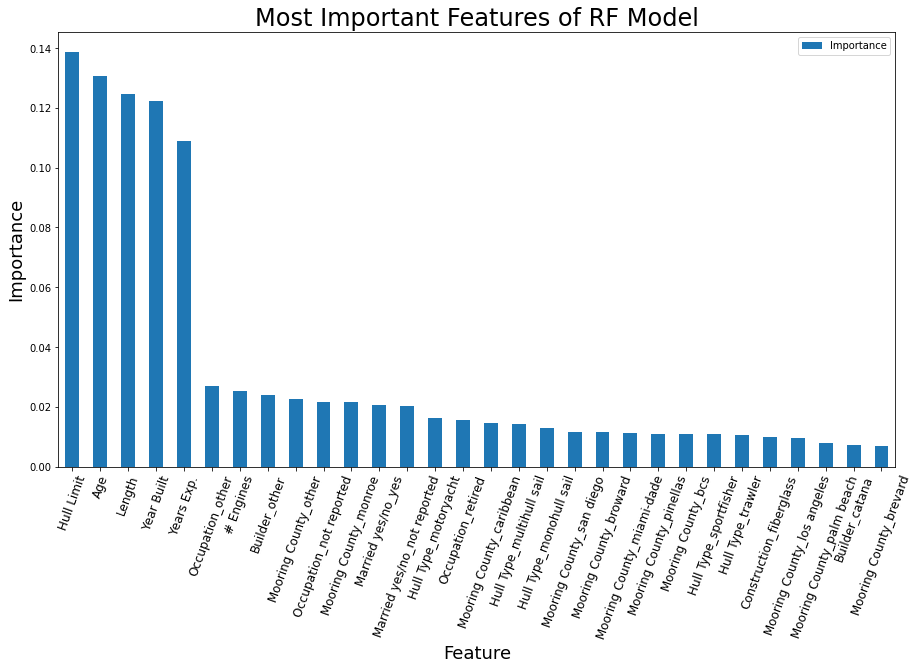

In [81]:
# View the feature importances

final_rf_feature_imp.plot(x = 'Variable', kind = 'bar', figsize= (15, 8))

plt.xticks(rotation= 70,fontsize = 12)
plt.xlabel('Feature',fontsize=18)
plt.ylabel('Importance', fontsize=18)
plt.title('Most Important Features of RF Model', fontsize=24)
plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight');

**INTERPRETATION:** According to our model, there are 5 most important features for predicting a claim:<br>
1. Hull Limit (price of the boat)
2. Age (of the owner)
3. Length  (of the boat)
4. Year Built (the boat)
5. Years Experience  (of the owner)

---
## Conclusion:

In this notebook we ran multiple models and continued to play around with them until we improved our results. Ultimately our best recall score was 45% which means out of all the policies that will actually have a claim, our model will predict 45% of them.